In [1]:
import struct
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fft import fft, fftshift

In [2]:
#Lo que deben realizar es escoger uno de los archivos “muestras_XXXMHz.bin” y analizar el espectro
#de las muestras capturadas y obtener el audio de cada una de las estaciones en el archivo de muestras elegido. 
data_bin = open('muestras_88_9.bin', 'rb');
data_array = np.fromfile(data_bin, 'int8')

#I +j*Q, I parte real, Q parte imaginaria.
señal_,I,Q = [],[],[]

for i in range(0,len(data_array)-1,2):
    I.append(data_array[i])
    Q.append(data_array[i+1])
    señal_.append(data_array[i]+1j*data_array[i+1])
I=np.array(I)
Q=np.array(Q)

In [3]:
señal=np.array(señal_)

In [4]:
"""Una muestra del espectro se almacena como dos componentes: una es la componente en fase
(I) y la otra es la componente en cuadratura (Q).
 Cada componente es de 8 bits y están representadas como signed ints.
 Las muestras están concatenadas, es decir, la n-ésima muestra de la componente en fase (8
bits) es seguida por la n-ésima muestra de la componente en cuadratura (8 bits), lo cual da que
la muestra total (ambas componentes) es de 16 bits.
#qq se refiere que lee 2 enteros de 8 bits cada uno.
print(int(len(data)/16))
señal= []
for i in range(int(len(data)/16)):
    I,Q=struct.unpack("@qq", data[16*i:16*(i+1)])
    # the complex data is  y = I + jQ.
    señal.append(I+1j*Q)
"""
señal[0:5]

array([-74.-119.j, -34. -10.j, -76. +79.j, -10. -80.j, -70.+105.j])

Text(0.5, 0, 'Frequency [Hz]')

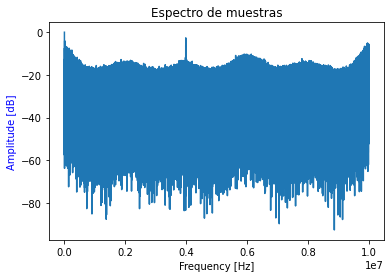

In [5]:
espectro = np.abs(fft(señal))
Espectro_normalizado=espectro/max(espectro);

plt.plot(20. * np.log10(Espectro_normalizado));
plt.title('Espectro de muestras')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')

In [6]:
"""
Tasa de muestreo: 1 MSamples/s.
 Número de muestras: 10 MSamples.
 Periodo de muestreo: 10 s.
"""
# fs corresponde a la frecuencia de muestreo
f, h = signal.freqz(señal,1,fs=1*10**6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


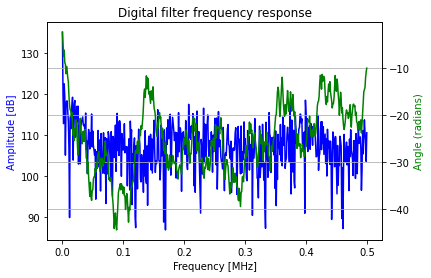

In [7]:
fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)

plt.plot(f/1e6 , 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [MHz]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(f/1e6, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()

In [8]:
!sudo apt-get install libportaudio2
!pip install sounddevice

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [9]:
import soundfile as sf
import sounddevice as sd

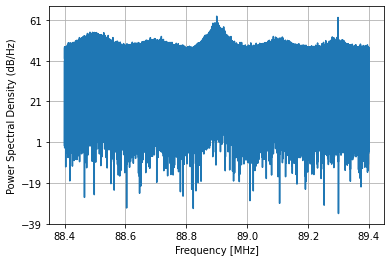

In [10]:
Fc = 88.9*(10**6) #Frecuencia central [Hz]
Fs = 10**6 #Frecuencia de muestreo [Hz]
"""
Encontramos la Densidad Espectral de Potencia, 
que nos entrega la distribución de la potencia de la señal
sobre las frecuencias que la forman
"""
plt.psd(señal,NFFT=10**7,Fs=Fs/1e6,Fc=Fc/1e6)
plt.xlabel('Frequency [MHz]')
plt.show()

In [11]:
car = np.exp(-1.0j*2.0*np.pi/Fs*np.arange(0,len(señal),1))
base = señal*np.transpose(car)

In [12]:
def FFT_Centrada(senal,n0,nf,fs,fc):
  # senal: la señal de la cual queremos observar su espectro.
  # n0: muestra inicial
  # nf: muestra final
  # fs: tasa o frecuencia de muestreo en MHz
  # fc: frecuencia de corte en MHz
  segmento = senal[n0:(n0+nf-1)] # Tomamos un trozo de la señal
  espectro = fftshift(fft(segmento)) # calculamos la FFT del segmento seleccionado
  z = 20*np.log10(abs(espectro)/max(abs(espectro))) # Encontramos la amplitud normalizada para el espectro encontrado
  Lf = fc-fs/2 # Límite inferior de la frecuencia
  Hf = fc+fs/2 # Límite superior de la frecuencia
  n = len(z) # largo del vector encontrado para la amplitud
  freq = np.arange(0,n,1)*fs/n+Lf # Permite crear el vector de frecuencias colocando el centro en la frecuencia de corte fc
  print(np.std(freq))
  plt.plot(freq,z) # Graficamos
  plt.axvspan(fc,fc, color='red',alpha=1) # Marca la línea en la frecuencia de corte
  """
  Definimos ejes
  """
  plt.title('Espectro de frecuencia centrado en '+str(fc)+'[MHz]')
  plt.xlabel('Frecuencia [MHz]')
  plt.ylabel('Amplitud Relativa')
  

0.28867513459477673


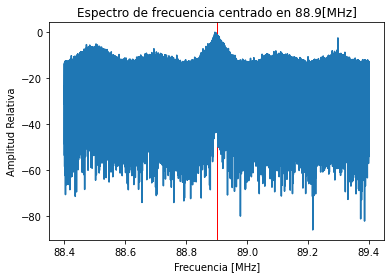

In [13]:
"""
Observamos el Espectro de la señal centrado
"""
FFT_Centrada(base,0,2*10**6,1,88.9)


De aquí en adelante falta arreglar

In [21]:
"""
Definimos la función para demodular la señal 
"""
def Ydem(senal):
  b = signal.firls(31,[0, 0.9],[0, 1])
  d = senal/abs(senal)
  rd = np.real(d)
  id = np.imag(d)
  return (rd*np.convolve(id,b,'same') - id*np.convolve(rd,b,'same'))/(rd**2+id**2)

In [22]:
dem = Ydem(base)
df = signal.decimate(dem,10,ftype='fir')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


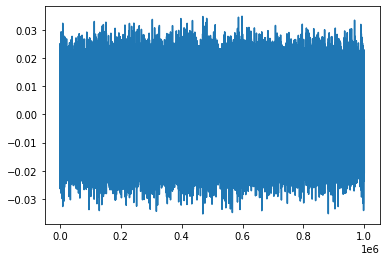

In [23]:
plt.plot(df)

In [17]:
df *= 10000/np.max(np.abs(df))

In [28]:
"""
Ahora analizamos el archvio "muestras_TV.bin" de la misma manera anterior.
"""
data_binTV = open('muestras_TV.bin', 'rb');
data_arrayTV = np.fromfile(data_binTV, 'int8')

#I +j*Q, I parte real, Q parte imaginaria.
señalTV_,ITV,QTV = [],[],[]

for i in range(0,len(data_arrayTV)-1,2):
    ITV.append(data_array[i])
    QTV.append(data_array[i+1])
    señalTV_.append(data_array[i]+1j*data_array[i+1])
ITV=np.array(ITV)
QTV=np.array(QTV)

In [29]:
señalTV=np.array(señalTV_)

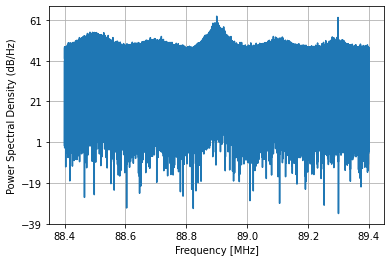

In [30]:
plt.psd(señalTV,NFFT=10**7,Fs=Fs/1e6,Fc=Fc/1e6)
plt.xlabel('Frequency [MHz]')
plt.show()

In [31]:
carTV = np.exp(-1.0j*2.0*np.pi/Fs*np.arange(0,len(señalTV),1))
baseTV = señalTV*np.transpose(carTV)

0.28867513459477673


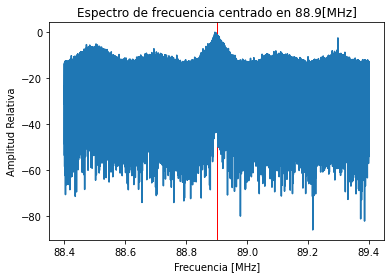

In [32]:
FFT_Centrada(baseTV,0,2*10**6,1,88.9)